In [227]:
from gio_model import GioModel
from constants import GioConstants
from math import sqrt
from time import sleep, time

import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

Turn off auto scrolling

In [2]:
%%javascript
require(
        ["notebook/js/outputarea"],
        function (oa) {
            oa.OutputArea.auto_scroll_threshold = -1;
        });

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import tensorflow as tf

tf.InteractiveSession()

ROOT_DIR = '/Users/abel/data'

def get_model(game_id):
    return GioModel.fromFile(ROOT_DIR + '/gio/models/%s.giomodel.gz' % (game_id))

models = os.listdir(ROOT_DIR + '/gio/models')
game_ids = map(lambda x: x[:x.find('.')], models)

In [4]:
model = get_model(game_ids[10])

print 'http://generals.io/replays/' + model.id

print model.ranks

http://generals.io/replays/B5-EAph8l
[7, 5, 3, 4, 0, 2, 6, 1]


In [5]:
model = get_model(game_ids[10])

print model.board_[0, 4, 1]
print model.isVisible(881, 4, 1, 7)

[ 1.  5.  4.]
True


In [6]:
owner_ch = model.board_[:, :, :, 1]
owner_ch[owner_ch == 1] = -2
owner_ch[owner_ch == 0] = 1
owner_ch[owner_ch == -2] = 0

Visualize channels for a random game:

http://generals.io/replays/B_E9uZbPl
[0, 1]


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


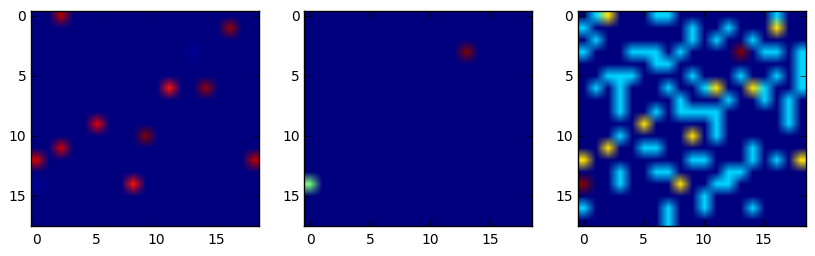

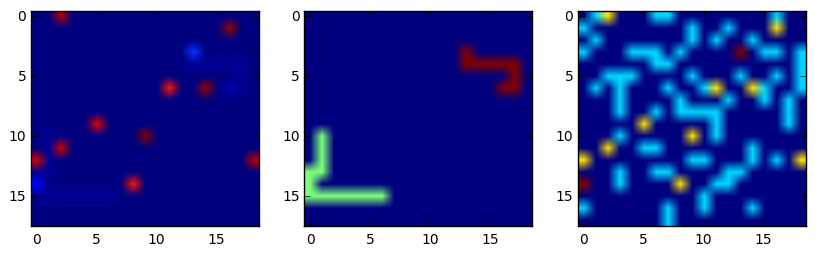

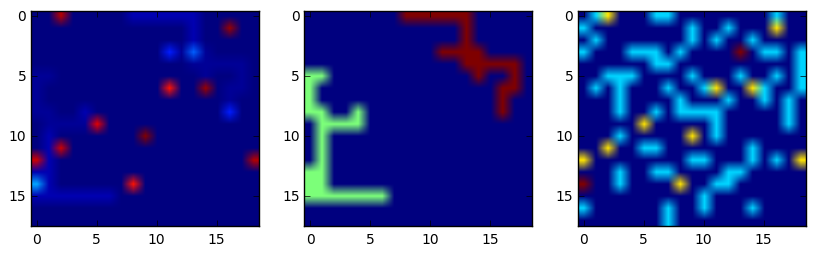

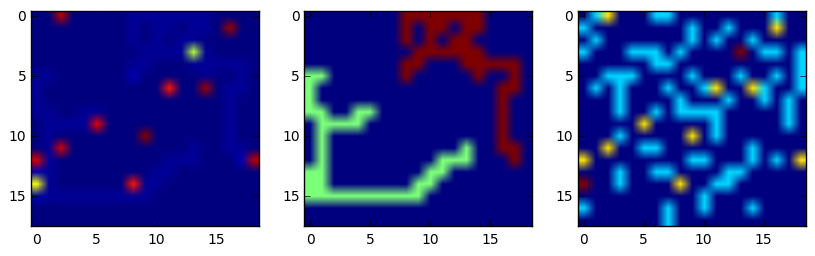

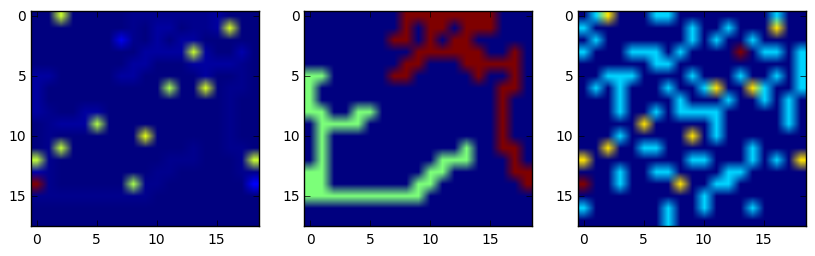

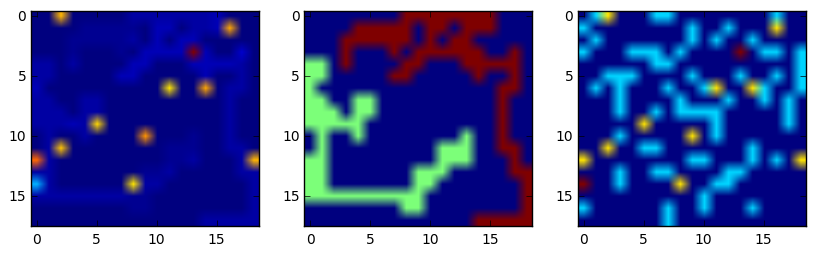

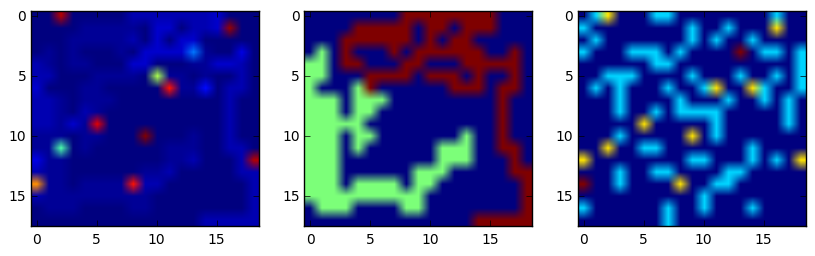

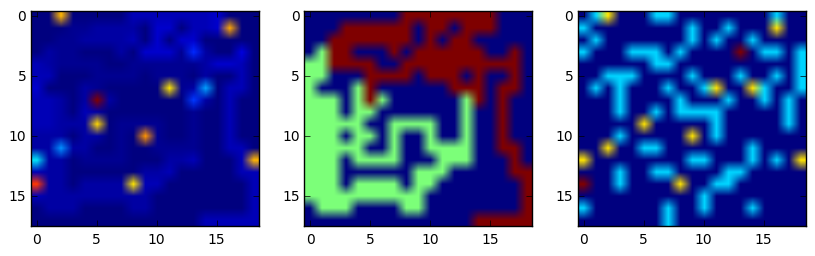

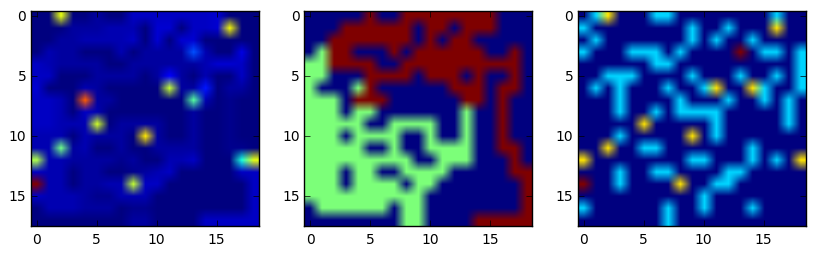

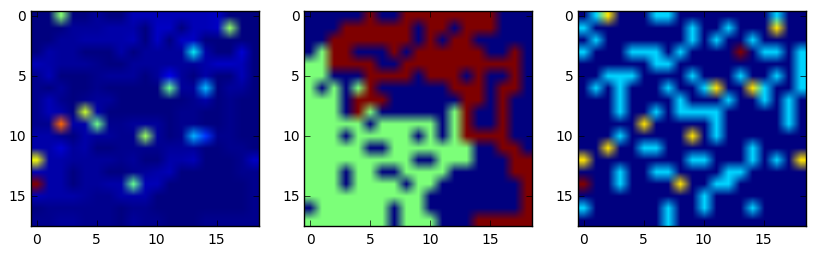

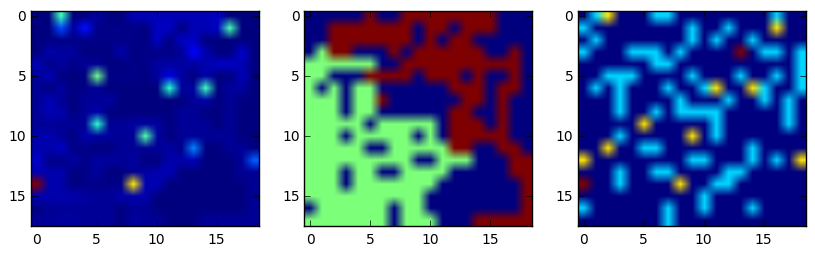

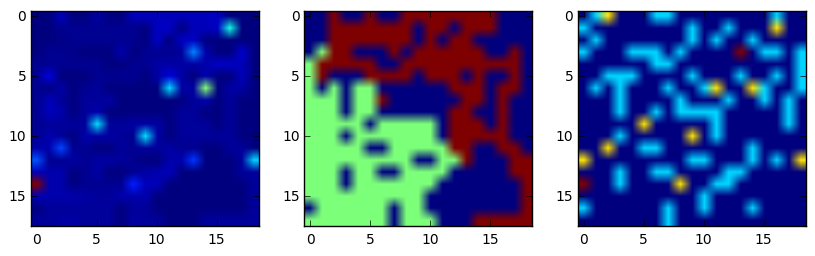

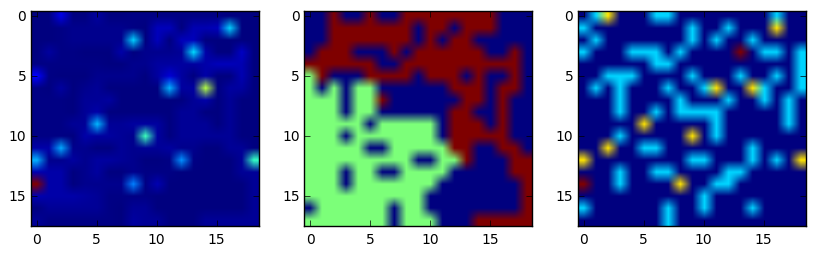

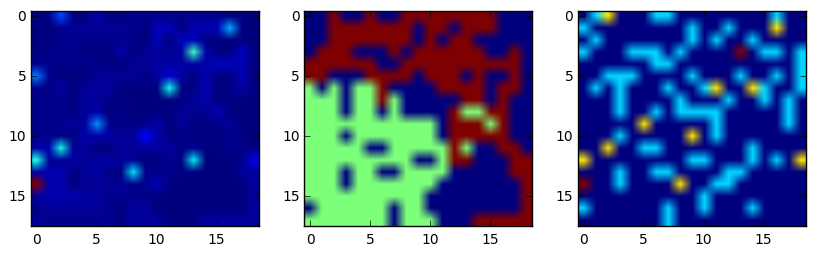

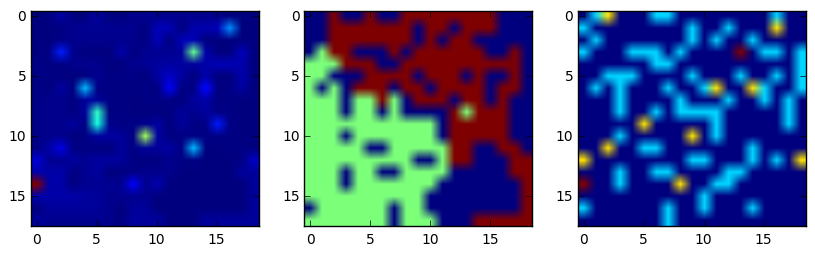

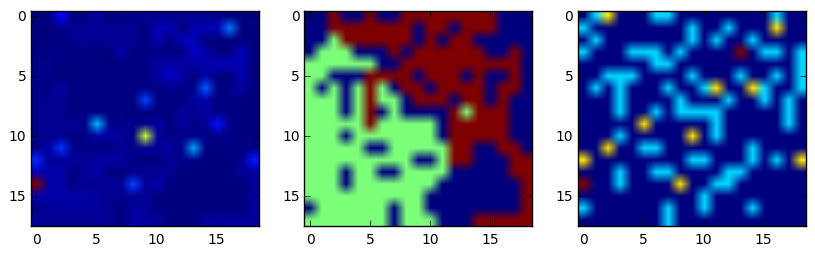

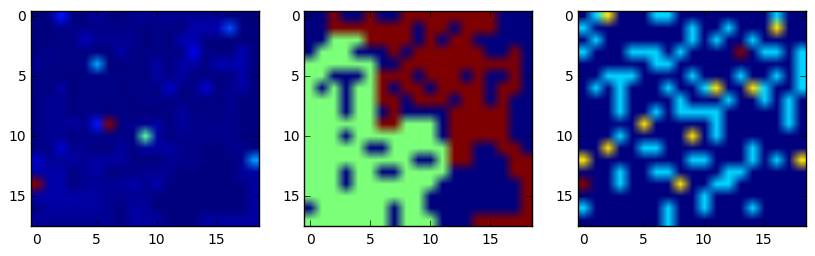

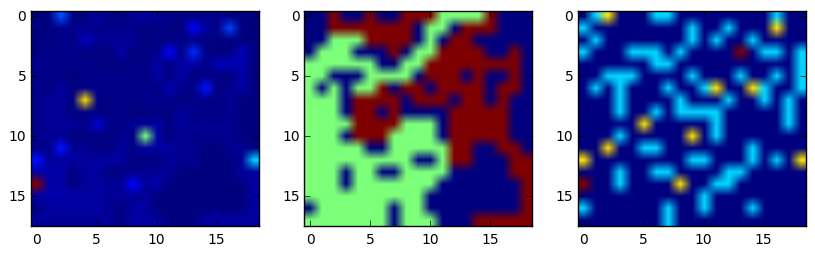

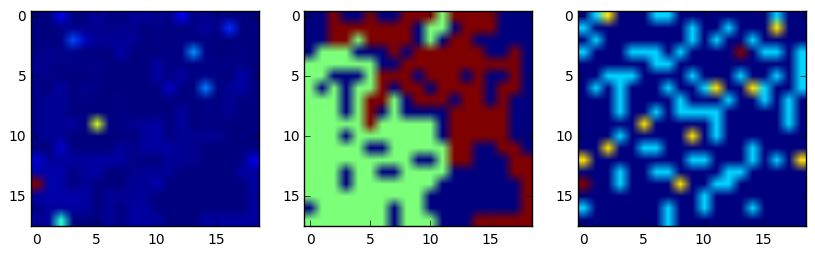

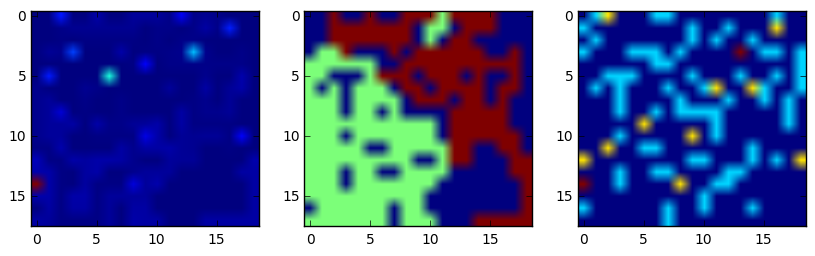

In [7]:
model = get_model(np.random.choice(game_ids, 1)[0])

def visualize_game(model, res=32, view=None):
    print 'http://generals.io/replays/' + model.id
    print model.ranks
    board = model.getBoardView(view) if view is not None else model.board_

    for i in range(board.shape[0] / res):
        turn = i * res
        fig, axs = plt.subplots(1, 3, figsize=(10, 10))
        for i in range(3):
            axs[i].imshow(board[turn][:, :, i])

visualize_game(model)

Visualize game from player-index 0's perspective:

http://generals.io/replays/B_E9uZbPl
[0, 1]


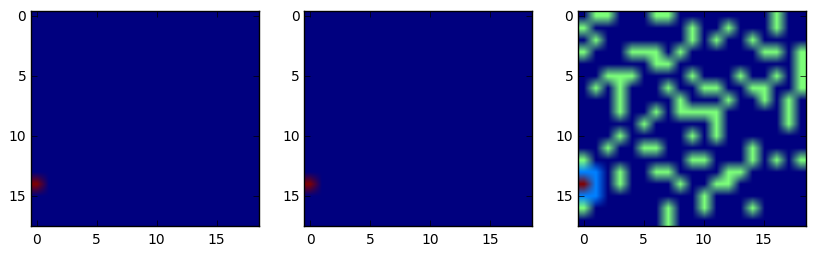

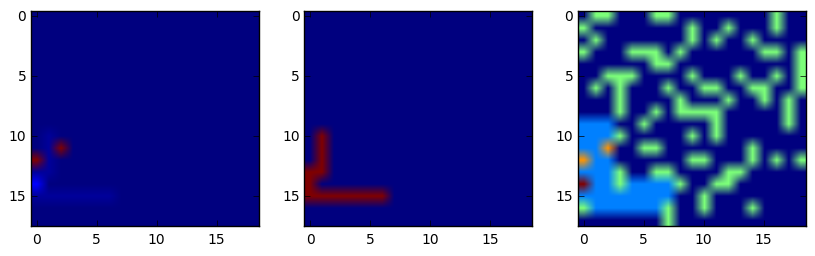

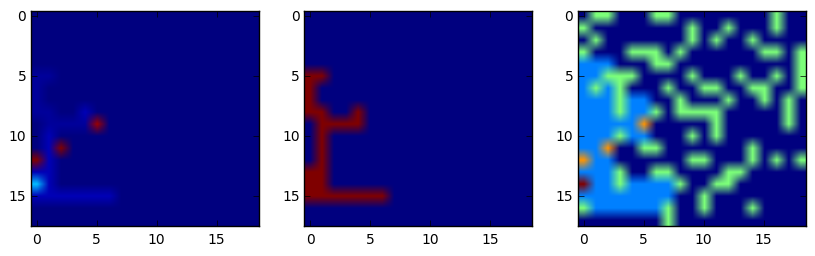

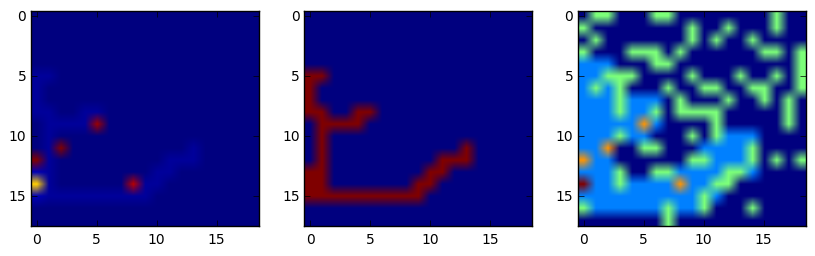

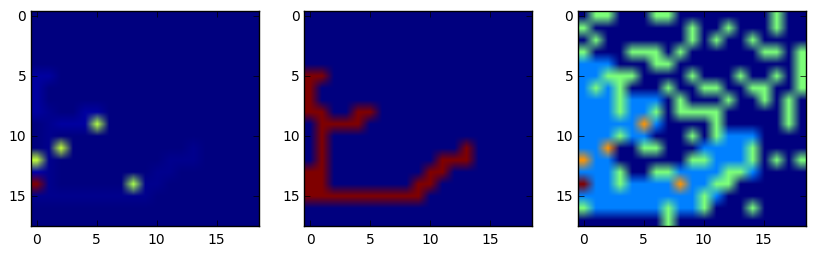

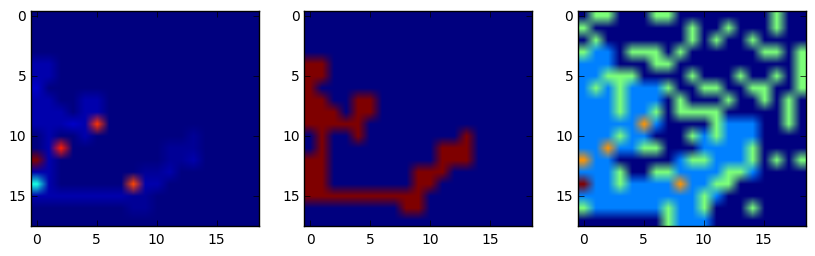

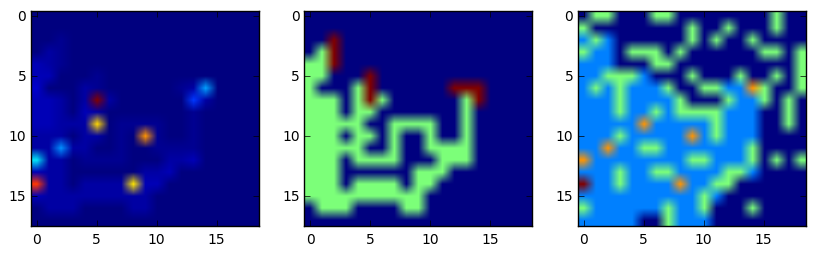

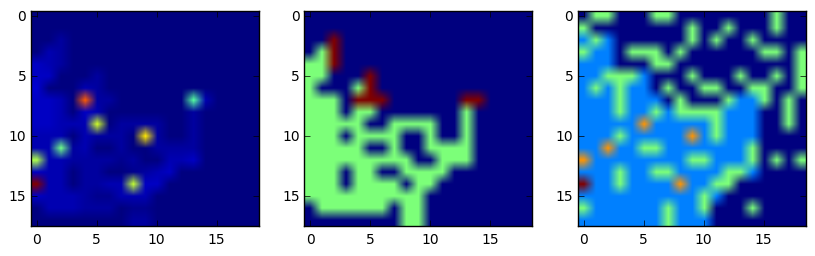

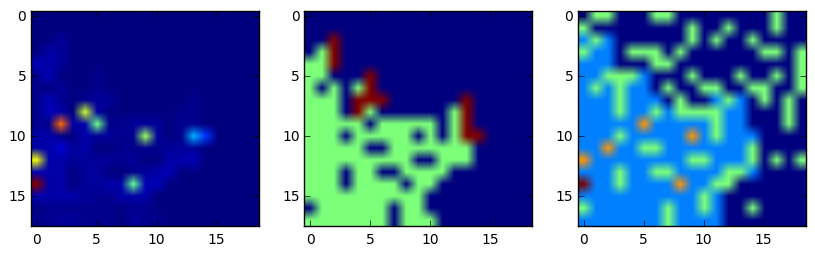

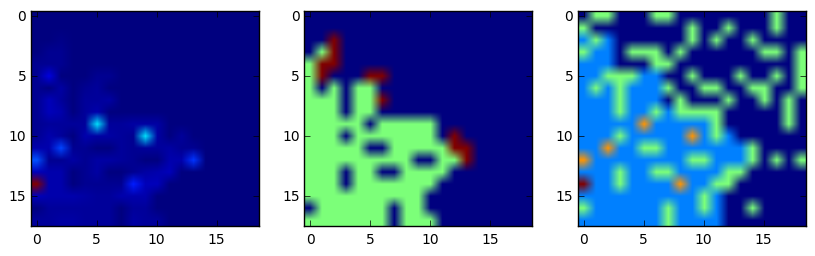

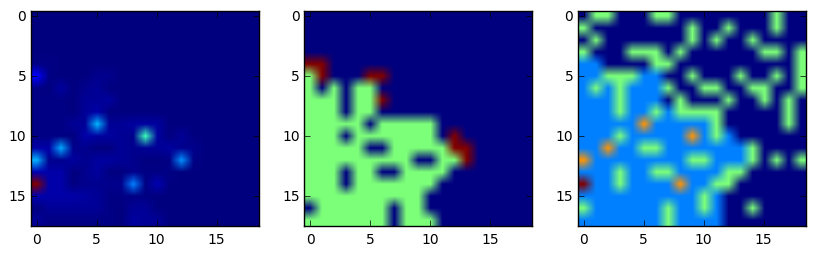

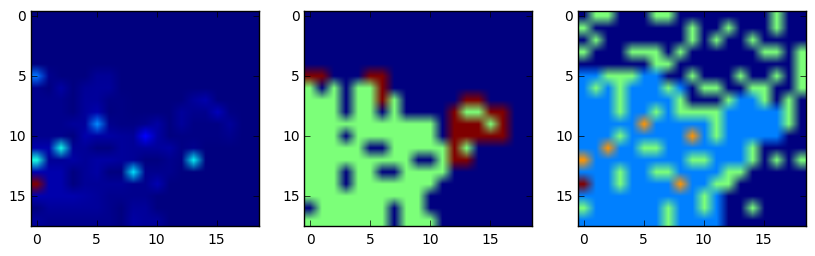

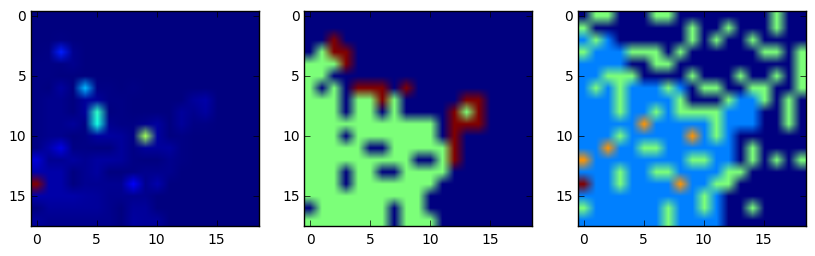

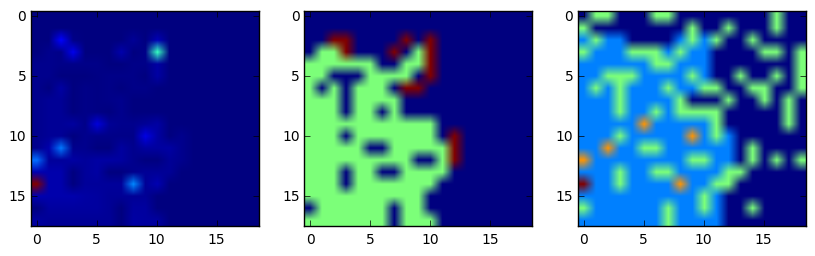

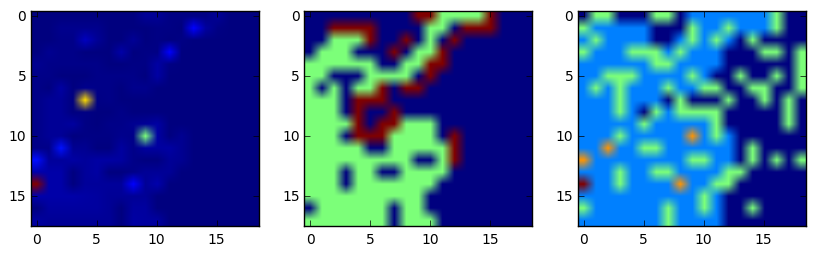

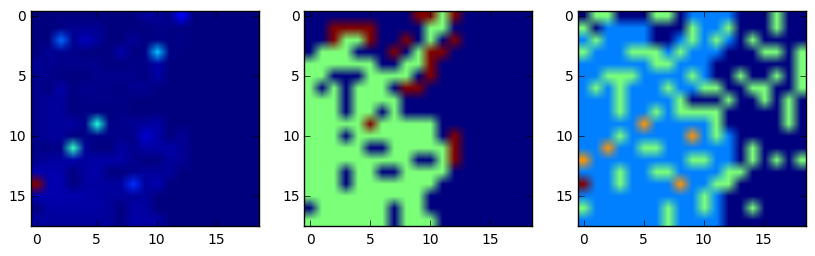

In [8]:
visualize_game(model, view=0)

In [9]:
scoreboard = model.getScoreBoard()
army_count = np.zeros((model.num_turns, 8))
army_count[:, :model.num_players] = scoreboard['army']

In [10]:
ex = tf.train.SequenceExample(
    context=tf.train.Features(feature={
        'a': tf.train.Feature(float_list=tf.train.FloatList(value=[0.5]))
    }),
    feature_lists=tf.train.FeatureLists(feature_list={
        'b': tf.train.FeatureList(feature=[
                tf.train.Feature(float_list=tf.train.FloatList(value=[1, 2])),
                tf.train.Feature(float_list=tf.train.FloatList(value=[3, 4]))])
    }))
print ex

context {
  feature {
    key: "a"
    value {
      float_list {
        value: 0.5
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "b"
    value {
      feature {
        float_list {
          value: 1
          value: 2
        }
      }
      feature {
        float_list {
          value: 3
          value: 4
        }
      }
    }
  }
}



In [11]:
context_features = { 'a': tf.FixedLenFeature([], dtype=tf.float32) }
sequence_features = { 'b': tf.FixedLenSequenceFeature([2], dtype=tf.float32) }
context, sequence = tf.parse_single_sequence_example(
  ex.SerializeToString(),
  context_features,
  sequence_features)

In [12]:
b_seq = sequence['b'].get_shape()

In [13]:
a = np.random.random((3, 2, 2, 2))
print a

[[[[ 0.05485141  0.45156295]
   [ 0.28262855  0.7307143 ]]

  [[ 0.69116978  0.04296067]
   [ 0.59156989  0.44187025]]]


 [[[ 0.505158    0.77766167]
   [ 0.13006903  0.16338005]]

  [[ 0.70103594  0.21474541]
   [ 0.39450643  0.48576331]]]


 [[[ 0.39490156  0.70629661]
   [ 0.34703457  0.20649096]]

  [[ 0.94002154  0.84990519]
   [ 0.67345234  0.22622828]]]]


In [174]:
tf.concat([tf.constant([[]]), tf.constant([[2, 2]], tf.float32)], 1).eval()

array([[ 2.,  2.]], dtype=float32)

In [14]:
tf.contrib.layers

<module 'tensorflow.contrib.layers' from '/usr/local/lib/python2.7/site-packages/tensorflow/contrib/layers/__init__.pyc'>

In [15]:
b = np.zeros((3, 3, 3, 2))
b[:a.shape[0], :a.shape[1], :a.shape[2], :a.shape[3]] = a

In [476]:
TFRecordOptions = tf.python_io.TFRecordOptions
TFRecordCompressionType = tf.python_io.TFRecordCompressionType

record_iterator = tf.python_io.tf_record_iterator("/Users/abel/data/gio/examples_tiny/train.tfrecords", options=TFRecordOptions(TFRecordCompressionType.GZIP));

In [490]:
record = record_iterator.next()

In [491]:
ex = tf.train.SequenceExample()
ex.ParseFromString(record)

In [492]:
ex.context

feature {
  key: "height"
  value {
    int64_list {
      value: 26
    }
  }
}
feature {
  key: "label"
  value {
    int64_list {
      value: 4
    }
  }
}
feature {
  key: "num_players"
  value {
    int64_list {
      value: 8
    }
  }
}
feature {
  key: "num_turns"
  value {
    int64_list {
      value: 208
    }
  }
}
feature {
  key: "width"
  value {
    int64_list {
      value: 23
    }
  }
}

In [493]:
serialized_example = ex.SerializeToString()

context_features_def = {
  'width': tf.FixedLenFeature([], dtype=tf.int64),
  'height': tf.FixedLenFeature([], dtype=tf.int64),
  'num_players': tf.FixedLenFeature([], dtype=tf.int64),
  'num_turns': tf.FixedLenFeature([], dtype=tf.int64),
  'label': tf.FixedLenFeature([], dtype=tf.int64)
}
board_size = GioConstants.max_width * \
    GioConstants.max_height * GioConstants.num_channels
sequence_features_def = {
  'board': tf.FixedLenSequenceFeature([board_size], dtype=tf.float32),
  'army_count': tf.FixedLenSequenceFeature([GioConstants.max_players],
                                           dtype=tf.float32),
  'fort_count': tf.FixedLenSequenceFeature([GioConstants.max_players],
                                           dtype=tf.float32),
  'land_count': tf.FixedLenSequenceFeature([GioConstants.max_players],
                                           dtype=tf.float32),
}
context_features, sequence_features = tf.parse_single_sequence_example(
    serialized=serialized_example,
    context_features=context_features_def,
    sequence_features=sequence_features_def)

In [494]:
board = tf.cast(sequence_features['board'], tf.float32)
army_count = tf.cast(sequence_features['army_count'], tf.float32)
land_count = tf.cast(sequence_features['land_count'], tf.float32)
fort_count = tf.cast(sequence_features['fort_count'], tf.float32)

In [499]:
fort_count.eval()[100:]

array([[ 1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.],
       [ 2.,  1.,  1

In [500]:
board_val = board.eval().reshape(-1, 32, 32, 3)

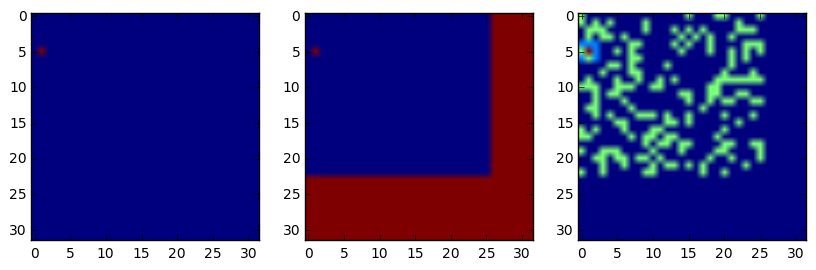

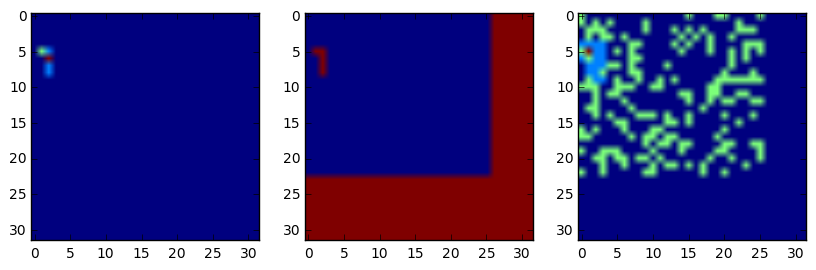

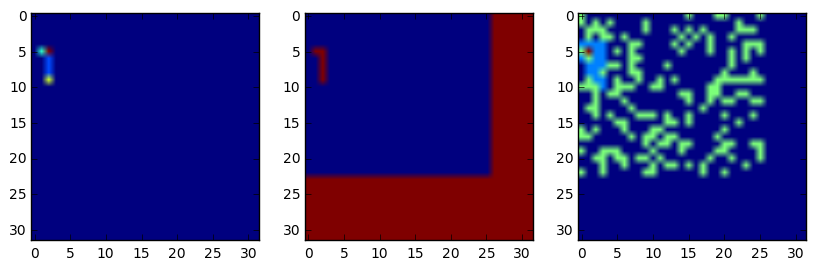

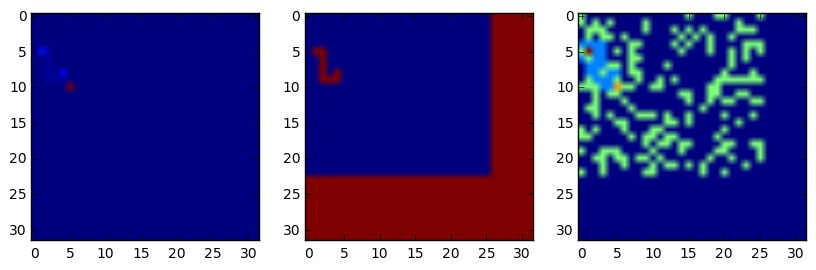

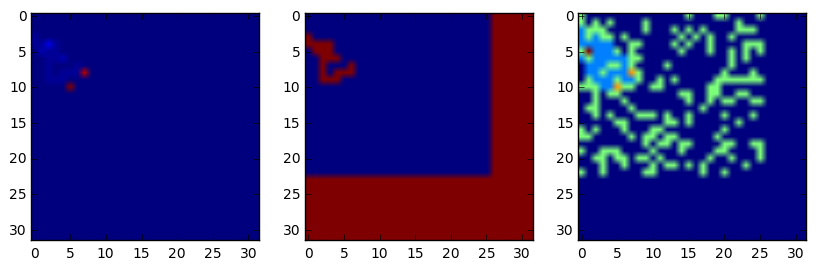

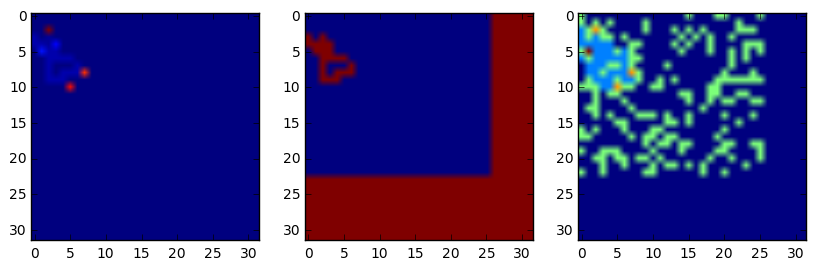

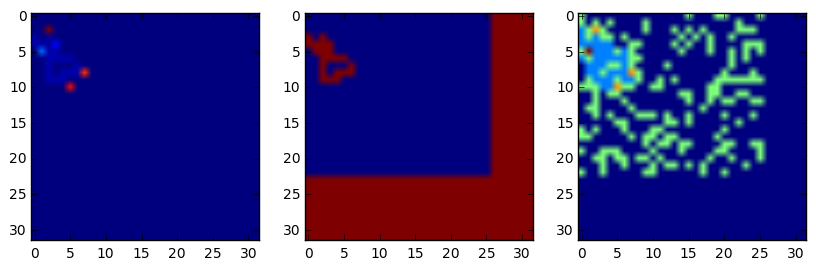

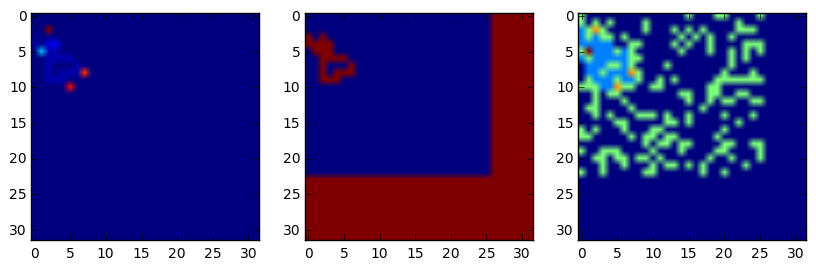

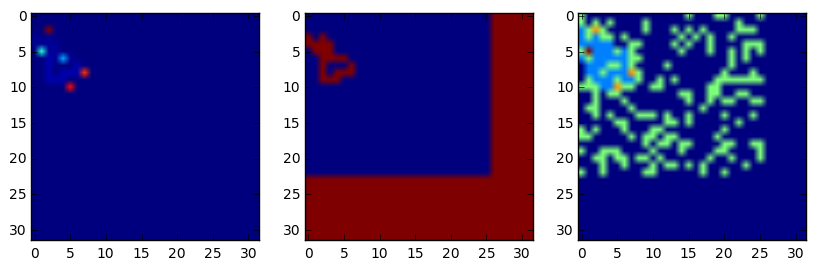

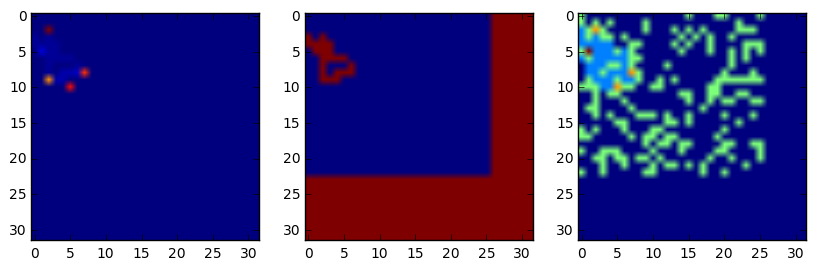

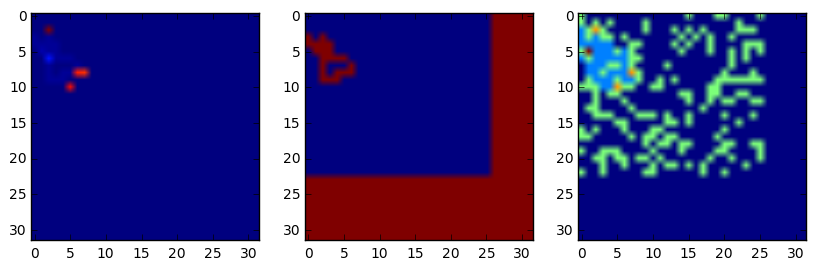

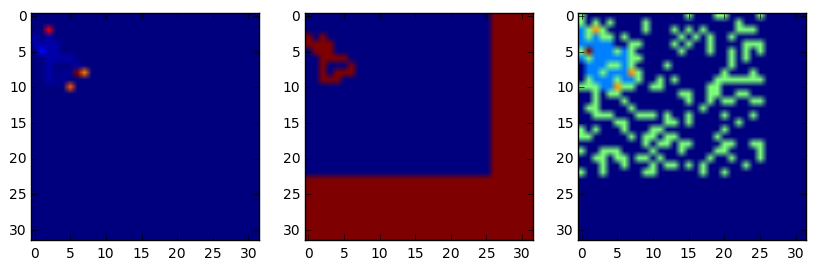

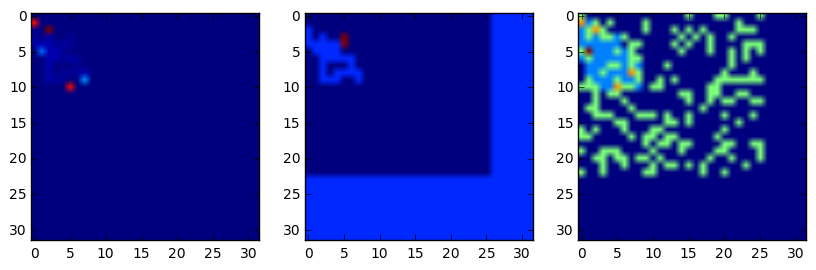

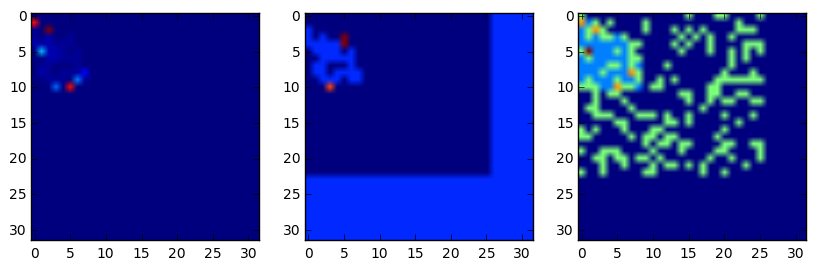

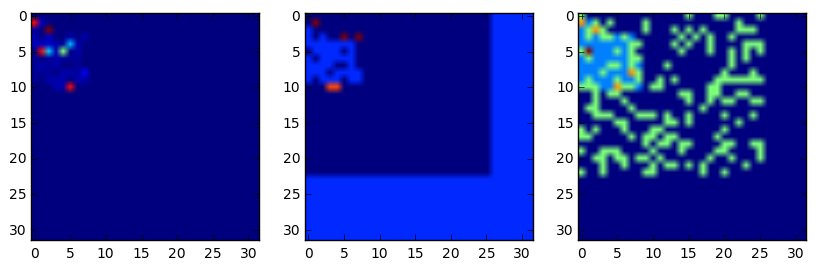

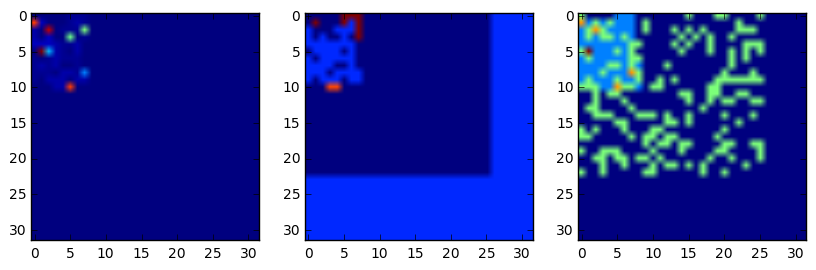

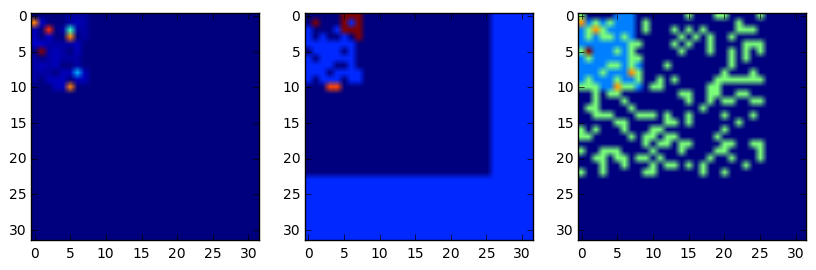

In [501]:
res = 8
for i in range(board_val.shape[0] / res):
    turn = i * res
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    for i in range(3):
        axs[i].imshow(board_val[turn][:, :, i])

In [ ]:
visualize_game(get_model(game_ids[0]))

In [68]:
b_100 = np.array(ex.feature_lists.feature_list['board'].feature[70].float_list.value, np.float32)

In [132]:
b_100.reshape(32, 32, 3).shape[:-1] + (1, )

(32, 32, 1)

In [20]:
a = np.random.random((3))
b = np.random.random((3))
print a
print b

[ 0.71928894  0.8685839   0.10414734]
[ 0.2412609   0.05205234  0.01313322]


In [21]:
tf.stack([tf.constant(a), tf.constant(b)], 1).eval()

array([[ 0.71928894,  0.2412609 ],
       [ 0.8685839 ,  0.05205234],
       [ 0.10414734,  0.01313322]])

In [78]:
a = tf.constant(np.reshape(b_100, (32, 32, 3)))

In [106]:
c = tf.constant([[[0.2], [0.8]], [[0.4], [0.6]]])

In [144]:
b_100.reshape(32, 32, 3)[:3, :3, 2]

array([[ 2.,  2.,  0.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  2.]], dtype=float32)

In [146]:
tf.one_hot(b_100.reshape(32, 32, 3)[:3, :3, 2] - 1, depth=4).eval()

array([[[ 0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.]]], dtype=float32)

In [116]:
x = tf.one_hot([[2, 1], [0, 0]], depth=3).eval()

In [117]:
y = tf.one_hot([[2, 2], [0, 0]], depth=3).eval()

In [135]:
tf.concat([tf.concat([c, x], 2), y], 2).eval()

array([[[ 0.2       ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  1.        ],
        [ 0.80000001,  0.        ,  1.        ,  0.        ,  0.        ,
          0.        ,  1.        ]],

       [[ 0.40000001,  1.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ],
        [ 0.60000002,  1.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ]]], dtype=float32)

In [182]:
a = np.random.random((2, 2, 2, 4))
print a

[[[[ 0.40611252  0.6238737   0.6557768   0.81041186]
   [ 0.57335335  0.04579015  0.12706337  0.25159161]]

  [[ 0.44427386  0.89062843  0.32232138  0.26786985]
   [ 0.05621752  0.36109555  0.4719213   0.86934227]]]


 [[[ 0.81175048  0.74799933  0.92577509  0.27973403]
   [ 0.51900648  0.55850246  0.77224297  0.02137444]]

  [[ 0.50896206  0.98402534  0.63735974  0.79112225]
   [ 0.20408734  0.79110283  0.77446737  0.44216023]]]]


In [183]:
b = np.random.random((2, 2, 2, 4))
print b

[[[[ 0.33182758  0.38936694  0.27507522  0.74551078]
   [ 0.39742228  0.69726615  0.39041966  0.27043151]]

  [[ 0.51680994  0.51158055  0.72350575  0.75236894]
   [ 0.64936798  0.46651771  0.34646139  0.23561638]]]


 [[[ 0.15112766  0.94604511  0.76722142  0.43589921]
   [ 0.21744653  0.71486731  0.16644587  0.12930158]]

  [[ 0.89008666  0.32514556  0.19937301  0.46639797]
   [ 0.96069645  0.9759655   0.73614558  0.63946038]]]]


In [192]:
a = tf.reshape(a, [2, 1, 2, 2, 4])
b = tf.reshape(b, [2, 1, 2, 2, 4])

In [194]:
tf.concat([a, b], 1).shape

TensorShape([Dimension(2), Dimension(2), Dimension(2), Dimension(2), Dimension(4)])

In [200]:
tf.contrib.layers.xavier_initializer

<tf.Tensor 'Reshape_2:0' shape=(2, 1, 2, 2, 4) dtype=float64>

In [207]:
tf.zeros((4, 0, 0)).eval()

array([], shape=(4, 0, 0), dtype=float32)